# 2025 DL Lab5: Object Detection on Pascal VOC

Before we start, please put **your name** and **SID** in following format: <br>
Hi I'm 陸仁賈, 314831000.

**Your Answer:**    
Hi I'm 吳禎哲, 313833003

## Overview

This project focuses on object detection using the Pascal VOC dataset. 

The goal is to identify and locate various objects within images by training and evaluating detection models.
 
The dataset provides annotated images across multiple categories, making it a standard benchmark for evaluating object detection performance.


## Kaggle Competition
Kaggle is an online community of data scientists and machine learning practitioners. Kaggle allows users to find and publish datasets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

This assignment use kaggle to calculate your grade.  
Please use this [**LINK**](https://www.kaggle.com/t/e86ea95cb007416a85a07d8729ac838e) to join the competition.

## Unzip Data

Unzip `dataset.zip` 

+ `vocall_test.txt` : list for the training set
+ `vocall_test.txt` : list for the validation set
+ `vocall_test.txt` : list for the test set
+ `image/` : contains all images.


The train set contains 8,218 images, the val set contains 3,823 images, and the test set contains 8,920 images.


#### You are allowed to use a **backbone model**, but only those available from the **timm package** (https://huggingface.co/timm/models).

# Import package

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from torch.amp import autocast, GradScaler
from src.yolo import getODmodel
from yolo_loss import YOLOv3Loss
from src.dataset import VocDetectorDataset, train_data_pipelines, test_data_pipelines, collate_fn
from src.eval_voc import evaluate
from src.config import GRID_SIZES, ANCHORS
from torch.optim.lr_scheduler import CosineAnnealingLR

/home/at0842/aaronwu901225master.ai13/.conda/envs/all-test/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#####hyperparameters#####
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 50
batch_size = 64
learning_rate = 1e-3
lambda_coord=5.0
lambda_obj=1.0
lambda_noobj=0.5
lambda_class=1.0

In [3]:
# Data paths
file_root_train = './dataset/image/'
annotation_file_train = './dataset/vocall_train.txt'
file_root_val = './dataset/image/'
annotation_file_val = './dataset/vocall_val.txt'
 # Data paths
file_root_train = './dataset/image/'
annotation_file_train = './dataset/vocall_train.txt'
file_root_val = './dataset/image/'
annotation_file_val = './dataset/vocall_val.txt'

# Create datasets
print('Loading datasets...')
train_dataset = VocDetectorDataset(
    root_img_dir=file_root_train,
    dataset_file=annotation_file_train,
    train=True,
    transform=train_data_pipelines,
    grid_sizes=GRID_SIZES,
    encode_target=True
)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    num_workers=4,
)
print(f'Loaded {len(train_dataset)} train images')

val_dataset = VocDetectorDataset(
    root_img_dir=file_root_val,
    dataset_file=annotation_file_val,
    train=False,
    transform=test_data_pipelines,
    grid_sizes=GRID_SIZES,
    encode_target=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    num_workers=4,
)
#for computing val maps
eval_dataset = VocDetectorDataset(
    root_img_dir=file_root_val,
    dataset_file=annotation_file_val,
    train=False,
    transform=test_data_pipelines,
    grid_sizes=GRID_SIZES,
    encode_target=False,
)
eval_loader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    num_workers=4
)
print(f'Loaded {len(val_dataset)} val images')

Loading datasets...
Initializing dataset
Loaded 8218 train images
Initializing dataset
Initializing dataset
Loaded 3823 val images


## Initialization

### Only backbone model on timm is acceptable (https://huggingface.co/timm/models).
### You can modify model name in yolo class

In [4]:
load_network_path = None #'checkpoints/best_detector.pth' 
pretrained = True
model = getODmodel(pretrained=pretrained).to(device)

### Some training utils, use mix precision if valid

In [5]:
# Create loss and optimizer
criterion = YOLOv3Loss(lambda_coord, lambda_obj, lambda_noobj, lambda_class, ANCHORS).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5e-4)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
use_amp = torch.cuda.is_available()
scaler = GradScaler(enabled=use_amp)

### Training Loop

In [6]:
# 建立紀錄容器：每個 epoch 紀錄一次
import numpy as np
history = {
    'train_total': [],
    'val_total': [],
    'map': [],
    'train_box': [],
    'train_obj': [],
    'train_noobj': [],
    'train_cls': [],
    'val_box': [],
    'val_obj': [],
    'val_noobj': [],
    'val_cls': []
}


In [7]:
# Training loop
print('\nStarting training...')
torch.cuda.empty_cache()
best_val_loss = np.inf
for epoch in range(num_epochs):
    model.train()
    print(f'\n\nStarting epoch {epoch + 1} / {num_epochs}')

    # 累積訓練 loss（本 epoch 平均）
    train_sum = {k: 0.0 for k in ['total','box','obj','noobj','cls']}
    train_batches = 0

    for i, (images, target) in enumerate(train_loader):
        # Move to device
        images = images.to(device)
        target = [t.to(device) for t in target]
        # Forward pass
        optimizer.zero_grad()
        with autocast("cuda", enabled=use_amp):
            pred = model(images)
            # pred and target are lists of each scales
            loss_dict = criterion(pred, target)
        # Backward pass with mixed precision support
        scaler.scale(loss_dict['total']).backward()
        scaler.step(optimizer)
        scaler.update()

        # 累積訓練統計
        for k in train_sum:
            train_sum[k] += float(loss_dict[k].detach().cpu())
        train_batches += 1

        # Print progress
        if i % 50 == 0:
            outstring = f'Epoch [{epoch+1}/{num_epochs}], Iter [{i+1}/{len(train_loader)}], Loss: '
            outstring += ', '.join(f"{key}={val :.3f}" for key, val in loss_dict.items())
            print(outstring)

    # epoch-end：學習率與平均訓練損失
    lr_scheduler.step()
    learning_rate = lr_scheduler.get_last_lr()[0]
    print(f'Learning Rate for this epoch: {learning_rate}')

    train_avg = {k: (train_sum[k] / max(train_batches, 1)) for k in train_sum}
    history['train_total'].append(train_avg['total'])
    history['train_box'].append(train_avg['box'])
    history['train_obj'].append(train_avg['obj'])
    history['train_noobj'].append(train_avg['noobj'])
    history['train_cls'].append(train_avg['cls'])

    # Validation
    with torch.no_grad():
        val_sum = {k: 0.0 for k in ['total','box','obj','noobj','cls']}
        model.eval()
        for i, (images, target) in enumerate(val_loader):
            # Move to device
            images = images.to(device)
            target = [t.to(device) for t in target]
            # Forward pass
            pred = model(images)
            loss_dict = criterion(pred, target)
            for k in val_sum:
                val_sum[k] += float(loss_dict[k].detach().cpu())

        val_avg = {k: (val_sum[k] / max(len(val_loader), 1)) for k in val_sum}
        print(f'Validation Loss: {val_avg["total"]:.4f}')

    # Save best model
    if best_val_loss > val_avg['total']:
        best_val_loss = val_avg['total']
        print(f'Updating best val loss: {best_val_loss:.5f}')
        os.makedirs('checkpoints', exist_ok=True)
        torch.save(model.state_dict(), 'checkpoints/best_detector.pth')

    # Save checkpoint
    if (epoch + 1) in [5, 10, 20, 30, 40]:
        torch.save(model.state_dict(), f'checkpoints/detector_epoch_{epoch+1}.pth')

    torch.save(model.state_dict(), 'checkpoints/detector.pth')

    # 紀錄驗證平均損失
    history['val_total'].append(val_avg['total'])
    history['val_box'].append(val_avg['box'])
    history['val_obj'].append(val_avg['obj'])
    history['val_noobj'].append(val_avg['noobj'])
    history['val_cls'].append(val_avg['cls'])

    # Evaluate on val set（每 5 個 epoch 計算一次 mAP）
    if (epoch + 1) % 5 == 0:
        print('\nEvaluating on validation set...')
        val_aps = evaluate(model, eval_loader)
        cur_map = float(np.mean(val_aps)) if len(val_aps) else 0.0
        print(f'Epoch {epoch+1}, mAP: {cur_map:.4f}')
        history['map'].append(cur_map)
    else:
        # 用 NaN 佔位，方便等長繪圖
        history['map'].append(float('nan'))



Starting training...


Starting epoch 1 / 50


Epoch [1/50], Iter [1/129], Loss: total=24.892, box=1.856, obj=0.709, noobj=0.664, cls=14.569


Epoch [1/50], Iter [51/129], Loss: total=11.218, box=1.508, obj=0.245, noobj=0.668, cls=3.096


Epoch [1/50], Iter [101/129], Loss: total=10.890, box=1.497, obj=0.135, noobj=0.525, cls=3.010


Learning Rate for this epoch: 0.0009990143508499217


Validation Loss: 11.3472
Updating best val loss: 11.34716




Starting epoch 2 / 50


Epoch [2/50], Iter [1/129], Loss: total=11.315, box=1.604, obj=0.222, noobj=0.486, cls=2.830


Epoch [2/50], Iter [51/129], Loss: total=10.479, box=1.537, obj=0.116, noobj=0.516, cls=2.418


Epoch [2/50], Iter [101/129], Loss: total=9.977, box=1.489, obj=0.089, noobj=0.444, cls=2.220


Learning Rate for this epoch: 0.0009960612933065818


Validation Loss: 10.6048
Updating best val loss: 10.60483




Starting epoch 3 / 50


Epoch [3/50], Iter [1/129], Loss: total=10.538, box=1.598, obj=0.102, noobj=0.445, cls=2.223


Epoch [3/50], Iter [51/129], Loss: total=10.021, box=1.498, obj=0.127, noobj=0.412, cls=2.200


Epoch [3/50], Iter [101/129], Loss: total=9.269, box=1.438, obj=0.100, noobj=0.391, cls=1.781


Learning Rate for this epoch: 0.00099115248173898


Validation Loss: 9.9712
Updating best val loss: 9.97118




Starting epoch 4 / 50


Epoch [4/50], Iter [1/129], Loss: total=9.621, box=1.493, obj=0.140, noobj=0.352, cls=1.839


Epoch [4/50], Iter [51/129], Loss: total=9.751, box=1.529, obj=0.095, noobj=0.351, cls=1.838


Epoch [4/50], Iter [101/129], Loss: total=9.548, box=1.497, obj=0.129, noobj=0.366, cls=1.750


Learning Rate for this epoch: 0.0009843072889837512


Validation Loss: 9.7013
Updating best val loss: 9.70133




Starting epoch 5 / 50


Epoch [5/50], Iter [1/129], Loss: total=8.905, box=1.460, obj=0.072, noobj=0.374, cls=1.346


Epoch [5/50], Iter [51/129], Loss: total=9.400, box=1.481, obj=0.065, noobj=0.338, cls=1.762


Epoch [5/50], Iter [101/129], Loss: total=8.757, box=1.418, obj=0.100, noobj=0.331, cls=1.400


Learning Rate for this epoch: 0.0009755527298894294


Validation Loss: 9.5941
Updating best val loss: 9.59407



Evaluating on validation set...
---Evaluate model on validation samples---


  0%|          | 0/60 [00:00<?, ?it/s]

  2%|▏         | 1/60 [00:01<01:43,  1.76s/it]

  3%|▎         | 2/60 [00:03<01:28,  1.52s/it]

  5%|▌         | 3/60 [00:04<01:15,  1.33s/it]

  7%|▋         | 4/60 [00:05<01:11,  1.27s/it]

  8%|▊         | 5/60 [00:06<01:08,  1.24s/it]

 10%|█         | 6/60 [00:07<01:03,  1.17s/it]

 12%|█▏        | 7/60 [00:08<01:01,  1.17s/it]

 13%|█▎        | 8/60 [00:09<01:00,  1.17s/it]

 15%|█▌        | 9/60 [00:11<01:00,  1.19s/it]

 17%|█▋        | 10/60 [00:12<01:00,  1.21s/it]

 18%|█▊        | 11/60 [00:13<00:58,  1.18s/it]

 20%|██        | 12/60 [00:14<00:55,  1.15s/it]

 22%|██▏       | 13/60 [00:15<00:55,  1.17s/it]

 23%|██▎       | 14/60 [00:16<00:52,  1.15s/it]

 25%|██▌       | 15/60 [00:18<00:50,  1.13s/it]

 27%|██▋       | 16/60 [00:19<00:48,  1.10s/it]

 28%|██▊       | 17/60 [00:20<00:47,  1.10s/it]

 30%|███       | 18/60 [00:21<00:46,  1.11s/it]

 32%|███▏      | 19/60 [00:22<00:45,  1.10s/it]

 33%|███▎      | 20/60 [00:23<00:44,  1.10s/it]

 35%|███▌      | 21/60 [00:24<00:44,  1.14s/it]

 37%|███▋      | 22/60 [00:25<00:42,  1.13s/it]

 38%|███▊      | 23/60 [00:26<00:40,  1.09s/it]

 40%|████      | 24/60 [00:27<00:38,  1.08s/it]

 42%|████▏     | 25/60 [00:29<00:38,  1.11s/it]

 43%|████▎     | 26/60 [00:30<00:37,  1.10s/it]

 45%|████▌     | 27/60 [00:31<00:37,  1.13s/it]

 47%|████▋     | 28/60 [00:32<00:36,  1.15s/it]

 48%|████▊     | 29/60 [00:33<00:35,  1.15s/it]

 50%|█████     | 30/60 [00:34<00:34,  1.16s/it]

 52%|█████▏    | 31/60 [00:35<00:33,  1.15s/it]

 53%|█████▎    | 32/60 [00:37<00:31,  1.12s/it]

 55%|█████▌    | 33/60 [00:38<00:30,  1.14s/it]

 57%|█████▋    | 34/60 [00:39<00:30,  1.16s/it]

 58%|█████▊    | 35/60 [00:40<00:29,  1.18s/it]

 60%|██████    | 36/60 [00:41<00:28,  1.18s/it]

 62%|██████▏   | 37/60 [00:43<00:27,  1.18s/it]

 63%|██████▎   | 38/60 [00:44<00:26,  1.21s/it]

 65%|██████▌   | 39/60 [00:45<00:26,  1.26s/it]

 67%|██████▋   | 40/60 [00:46<00:24,  1.23s/it]

 68%|██████▊   | 41/60 [00:48<00:22,  1.21s/it]

 70%|███████   | 42/60 [00:49<00:21,  1.21s/it]

 72%|███████▏  | 43/60 [00:50<00:20,  1.18s/it]

 73%|███████▎  | 44/60 [00:51<00:18,  1.16s/it]

 75%|███████▌  | 45/60 [00:52<00:17,  1.18s/it]

 77%|███████▋  | 46/60 [00:53<00:16,  1.16s/it]

 78%|███████▊  | 47/60 [00:54<00:15,  1.16s/it]

 80%|████████  | 48/60 [00:56<00:13,  1.14s/it]

 82%|████████▏ | 49/60 [00:57<00:12,  1.16s/it]

 83%|████████▎ | 50/60 [00:58<00:11,  1.13s/it]

 85%|████████▌ | 51/60 [00:59<00:10,  1.13s/it]

 87%|████████▋ | 52/60 [01:00<00:09,  1.13s/it]

 88%|████████▊ | 53/60 [01:01<00:07,  1.11s/it]

 90%|█████████ | 54/60 [01:02<00:06,  1.10s/it]

 92%|█████████▏| 55/60 [01:03<00:05,  1.15s/it]

 93%|█████████▎| 56/60 [01:05<00:04,  1.11s/it]

 95%|█████████▌| 57/60 [01:06<00:03,  1.18s/it]

 97%|█████████▋| 58/60 [01:07<00:02,  1.17s/it]

 98%|█████████▊| 59/60 [01:08<00:01,  1.18s/it]

100%|██████████| 60/60 [01:09<00:00,  1.07s/it]

100%|██████████| 60/60 [01:09<00:00,  1.16s/it]

---class aeroplane ap 0.12703787276420392---
---class bicycle ap 0.0474032772496088---
---class bird ap 0.04913297391895812---


---class boat ap 0.00962419200237066---


---class bottle ap 0.03540785038473295---
---class bus ap 0.10957031911168276---


---class car ap 0.12310228073742244---
---class cat ap 0.27662847151300735---


---class chair ap 0.04602715279584571---
---class cow ap 0.0006812309137890532---
---class diningtable ap 0.12658325522477656---
---class dog ap 0.1656920624811738---
---class horse ap 0.17838619853957494---
---class motorbike ap 0.20318611181073926---


---class person ap 0.2391443008287764---


---class pottedplant ap 0.05611278344724209---
---class sheep ap 0.006136884216076177---


---class sofa ap 0.1896433112418766---
---class train ap 0.1527378164602695---
---class tvmonitor ap 0.03257122672816872---
---map 0.10874047861851477---
Epoch 5, mAP: 0.1087


Starting epoch 6 / 50


Epoch [6/50], Iter [1/129], Loss: total=9.536, box=1.546, obj=0.123, noobj=0.329, cls=1.520


Epoch [6/50], Iter [51/129], Loss: total=8.590, box=1.421, obj=0.074, noobj=0.333, cls=1.243


Epoch [6/50], Iter [101/129], Loss: total=9.344, box=1.547, obj=0.141, noobj=0.293, cls=1.320


Learning Rate for this epoch: 0.0009649233547011816


Validation Loss: 9.4110
Updating best val loss: 9.41102




Starting epoch 7 / 50


Epoch [7/50], Iter [1/129], Loss: total=8.785, box=1.448, obj=0.092, noobj=0.296, cls=1.304


Epoch [7/50], Iter [51/129], Loss: total=9.059, box=1.526, obj=0.060, noobj=0.319, cls=1.208


Epoch [7/50], Iter [101/129], Loss: total=9.314, box=1.545, obj=0.064, noobj=0.313, cls=1.371


Learning Rate for this epoch: 0.0009524611127067769


Validation Loss: 9.3926
Updating best val loss: 9.39264




Starting epoch 8 / 50


Epoch [8/50], Iter [1/129], Loss: total=8.891, box=1.493, obj=0.080, noobj=0.287, cls=1.204


Epoch [8/50], Iter [51/129], Loss: total=8.512, box=1.457, obj=0.114, noobj=0.311, cls=0.955


Epoch [8/50], Iter [101/129], Loss: total=8.699, box=1.478, obj=0.106, noobj=0.291, cls=1.060


Learning Rate for this epoch: 0.0009382151866819099


Validation Loss: 9.0399
Updating best val loss: 9.03991




Starting epoch 9 / 50


Epoch [9/50], Iter [1/129], Loss: total=8.603, box=1.450, obj=0.087, noobj=0.281, cls=1.124


Epoch [9/50], Iter [51/129], Loss: total=8.721, box=1.462, obj=0.113, noobj=0.262, cls=1.167


Epoch [9/50], Iter [101/129], Loss: total=8.446, box=1.453, obj=0.108, noobj=0.280, cls=0.933


Learning Rate for this epoch: 0.0009222417987882566


Validation Loss: 9.0709




Starting epoch 10 / 50


Epoch [10/50], Iter [1/129], Loss: total=8.400, box=1.473, obj=0.034, noobj=0.262, cls=0.869


Epoch [10/50], Iter [51/129], Loss: total=8.128, box=1.439, obj=0.046, noobj=0.249, cls=0.761


Epoch [10/50], Iter [101/129], Loss: total=8.662, box=1.465, obj=0.065, noobj=0.299, cls=1.125


Learning Rate for this epoch: 0.0009046039886902864


Validation Loss: 9.1905



Evaluating on validation set...
---Evaluate model on validation samples---


  0%|          | 0/60 [00:00<?, ?it/s]

  2%|▏         | 1/60 [00:02<02:26,  2.48s/it]

  3%|▎         | 2/60 [00:04<02:02,  2.11s/it]

  5%|▌         | 3/60 [00:05<01:47,  1.88s/it]

  7%|▋         | 4/60 [00:07<01:43,  1.85s/it]

  8%|▊         | 5/60 [00:09<01:40,  1.83s/it]

 10%|█         | 6/60 [00:11<01:35,  1.76s/it]

 12%|█▏        | 7/60 [00:12<01:31,  1.73s/it]

 13%|█▎        | 8/60 [00:14<01:28,  1.71s/it]

 15%|█▌        | 9/60 [00:16<01:29,  1.75s/it]

 17%|█▋        | 10/60 [00:18<01:28,  1.78s/it]

 18%|█▊        | 11/60 [00:19<01:26,  1.77s/it]

 20%|██        | 12/60 [00:21<01:24,  1.76s/it]

 22%|██▏       | 13/60 [00:23<01:25,  1.82s/it]

 23%|██▎       | 14/60 [00:25<01:25,  1.86s/it]

 25%|██▌       | 15/60 [00:27<01:22,  1.83s/it]

 27%|██▋       | 16/60 [00:28<01:15,  1.73s/it]

 28%|██▊       | 17/60 [00:30<01:15,  1.75s/it]

 30%|███       | 18/60 [00:32<01:14,  1.78s/it]

 32%|███▏      | 19/60 [00:34<01:11,  1.75s/it]

 33%|███▎      | 20/60 [00:35<01:09,  1.74s/it]

 35%|███▌      | 21/60 [00:37<01:06,  1.71s/it]

 37%|███▋      | 22/60 [00:39<01:03,  1.68s/it]

 38%|███▊      | 23/60 [00:40<01:01,  1.66s/it]

 40%|████      | 24/60 [00:42<01:02,  1.73s/it]

 42%|████▏     | 25/60 [00:44<01:01,  1.75s/it]

 43%|████▎     | 26/60 [00:46<00:59,  1.75s/it]

 45%|████▌     | 27/60 [00:47<00:57,  1.75s/it]

 47%|████▋     | 28/60 [00:49<00:56,  1.78s/it]

 48%|████▊     | 29/60 [00:51<00:55,  1.80s/it]

 50%|█████     | 30/60 [00:53<00:53,  1.78s/it]

 52%|█████▏    | 31/60 [00:55<00:51,  1.76s/it]

 53%|█████▎    | 32/60 [00:56<00:47,  1.71s/it]

 55%|█████▌    | 33/60 [00:58<00:46,  1.73s/it]

 57%|█████▋    | 34/60 [01:00<00:46,  1.78s/it]

 58%|█████▊    | 35/60 [01:02<00:46,  1.85s/it]

 60%|██████    | 36/60 [01:04<00:44,  1.86s/it]

 62%|██████▏   | 37/60 [01:06<00:42,  1.86s/it]

 63%|██████▎   | 38/60 [01:08<00:41,  1.90s/it]

 65%|██████▌   | 39/60 [01:09<00:38,  1.85s/it]

 67%|██████▋   | 40/60 [01:11<00:37,  1.86s/it]

 68%|██████▊   | 41/60 [01:13<00:34,  1.84s/it]

 70%|███████   | 42/60 [01:15<00:33,  1.88s/it]

 72%|███████▏  | 43/60 [01:17<00:31,  1.83s/it]

 73%|███████▎  | 44/60 [01:18<00:28,  1.78s/it]

 75%|███████▌  | 45/60 [01:20<00:26,  1.78s/it]

 77%|███████▋  | 46/60 [01:22<00:24,  1.75s/it]

 78%|███████▊  | 47/60 [01:24<00:23,  1.78s/it]

 80%|████████  | 48/60 [01:25<00:21,  1.80s/it]

 82%|████████▏ | 49/60 [01:27<00:19,  1.81s/it]

 83%|████████▎ | 50/60 [01:29<00:17,  1.79s/it]

 85%|████████▌ | 51/60 [01:31<00:15,  1.77s/it]

 87%|████████▋ | 52/60 [01:32<00:14,  1.76s/it]

 88%|████████▊ | 53/60 [01:34<00:11,  1.71s/it]

 90%|█████████ | 54/60 [01:36<00:10,  1.70s/it]

 92%|█████████▏| 55/60 [01:38<00:08,  1.76s/it]

 93%|█████████▎| 56/60 [01:39<00:06,  1.69s/it]

 95%|█████████▌| 57/60 [01:41<00:05,  1.73s/it]

 97%|█████████▋| 58/60 [01:43<00:03,  1.73s/it]

 98%|█████████▊| 59/60 [01:45<00:01,  1.78s/it]

100%|██████████| 60/60 [01:46<00:00,  1.62s/it]

100%|██████████| 60/60 [01:46<00:00,  1.77s/it]

---class aeroplane ap 0.26065520456580205---
---class bicycle ap 0.1922000137565284---
---class bird ap 0.13063967169036242---


---class boat ap 0.02230903814835174---


---class bottle ap 0.009530152797794622---
---class bus ap 0.23870921332125786---


---class car ap 0.1301948898310284---
---class cat ap 0.3386584833643045---


---class chair ap 0.051814701855134544---
---class cow ap 0.005995825087680649---
---class diningtable ap 0.06179979401524592---
---class dog ap 0.17864343065137875---
---class horse ap 0.1956379630327358---
---class motorbike ap 0.2572844525553379---


---class person ap 0.08455257028686083---


---class pottedplant ap 0.034706658974827456---
---class sheep ap 0.015083634978902352---
---class sofa ap 0.11091564313954705---
---class train ap 0.2840745856100365---
---class tvmonitor ap 0.1440622939301558---
---map 0.13737341107966367---


Epoch 10, mAP: 0.1374


Starting epoch 11 / 50


Epoch [11/50], Iter [1/129], Loss: total=8.741, box=1.493, obj=0.085, noobj=0.265, cls=1.059


Epoch [11/50], Iter [51/129], Loss: total=8.249, box=1.470, obj=0.059, noobj=0.247, cls=0.717


Epoch [11/50], Iter [101/129], Loss: total=8.155, box=1.466, obj=0.088, noobj=0.252, cls=0.613


Learning Rate for this epoch: 0.0008853713647665069


Validation Loss: 8.9080
Updating best val loss: 8.90804




Starting epoch 12 / 50


Epoch [12/50], Iter [1/129], Loss: total=8.193, box=1.454, obj=0.088, noobj=0.258, cls=0.708


Epoch [12/50], Iter [51/129], Loss: total=7.790, box=1.411, obj=0.043, noobj=0.239, cls=0.575


Epoch [12/50], Iter [101/129], Loss: total=8.651, box=1.507, obj=0.110, noobj=0.218, cls=0.898


Learning Rate for this epoch: 0.0008646198293969952


Validation Loss: 9.0516




Starting epoch 13 / 50


Epoch [13/50], Iter [1/129], Loss: total=8.929, box=1.519, obj=0.107, noobj=0.243, cls=1.104


Epoch [13/50], Iter [51/129], Loss: total=8.336, box=1.518, obj=0.061, noobj=0.243, cls=0.566


Epoch [13/50], Iter [101/129], Loss: total=7.884, box=1.397, obj=0.076, noobj=0.246, cls=0.700


Learning Rate for this epoch: 0.0008424312794113801


Validation Loss: 9.0369




Starting epoch 14 / 50


Epoch [14/50], Iter [1/129], Loss: total=8.735, box=1.469, obj=0.081, noobj=0.256, cls=1.179


Epoch [14/50], Iter [51/129], Loss: total=8.347, box=1.435, obj=0.079, noobj=0.237, cls=0.976


Epoch [14/50], Iter [101/129], Loss: total=8.558, box=1.498, obj=0.077, noobj=0.252, cls=0.864


Learning Rate for this epoch: 0.0008188932828794706


Validation Loss: 8.8954
Updating best val loss: 8.89542




Starting epoch 15 / 50


Epoch [15/50], Iter [1/129], Loss: total=8.187, box=1.459, obj=0.075, noobj=0.252, cls=0.693


Epoch [15/50], Iter [51/129], Loss: total=7.854, box=1.397, obj=0.036, noobj=0.221, cls=0.725


Epoch [15/50], Iter [101/129], Loss: total=7.969, box=1.441, obj=0.054, noobj=0.216, cls=0.601


Learning Rate for this epoch: 0.0007940987335200906


Validation Loss: 8.7148
Updating best val loss: 8.71476



Evaluating on validation set...
---Evaluate model on validation samples---


  0%|          | 0/60 [00:00<?, ?it/s]

  2%|▏         | 1/60 [00:01<01:39,  1.68s/it]

  3%|▎         | 2/60 [00:02<01:18,  1.35s/it]

  5%|▌         | 3/60 [00:03<01:08,  1.20s/it]

  7%|▋         | 4/60 [00:04<01:03,  1.14s/it]

  8%|▊         | 5/60 [00:05<01:00,  1.11s/it]

 10%|█         | 6/60 [00:06<00:58,  1.08s/it]

 12%|█▏        | 7/60 [00:07<00:56,  1.06s/it]

 13%|█▎        | 8/60 [00:08<00:54,  1.04s/it]

 15%|█▌        | 9/60 [00:10<00:53,  1.05s/it]

 17%|█▋        | 10/60 [00:11<00:53,  1.07s/it]

 18%|█▊        | 11/60 [00:12<00:52,  1.08s/it]

 20%|██        | 12/60 [00:13<00:51,  1.07s/it]

 22%|██▏       | 13/60 [00:14<00:50,  1.08s/it]

 23%|██▎       | 14/60 [00:15<00:48,  1.06s/it]

 25%|██▌       | 15/60 [00:16<00:47,  1.06s/it]

 27%|██▋       | 16/60 [00:17<00:45,  1.03s/it]

 28%|██▊       | 17/60 [00:18<00:44,  1.05s/it]

 30%|███       | 18/60 [00:19<00:44,  1.07s/it]

 32%|███▏      | 19/60 [00:20<00:43,  1.05s/it]

 33%|███▎      | 20/60 [00:21<00:41,  1.04s/it]

 35%|███▌      | 21/60 [00:22<00:40,  1.04s/it]

 37%|███▋      | 22/60 [00:23<00:38,  1.02s/it]

 38%|███▊      | 23/60 [00:24<00:36,  1.00it/s]

 40%|████      | 24/60 [00:25<00:36,  1.02s/it]

 42%|████▏     | 25/60 [00:26<00:36,  1.05s/it]

 43%|████▎     | 26/60 [00:27<00:36,  1.06s/it]

 45%|████▌     | 27/60 [00:28<00:35,  1.07s/it]

 47%|████▋     | 28/60 [00:30<00:34,  1.09s/it]

 48%|████▊     | 29/60 [00:31<00:34,  1.10s/it]

 50%|█████     | 30/60 [00:32<00:32,  1.09s/it]

 52%|█████▏    | 31/60 [00:33<00:31,  1.08s/it]

 53%|█████▎    | 32/60 [00:34<00:29,  1.04s/it]

 55%|█████▌    | 33/60 [00:35<00:28,  1.07s/it]

 57%|█████▋    | 34/60 [00:36<00:27,  1.07s/it]

 58%|█████▊    | 35/60 [00:37<00:26,  1.05s/it]

 60%|██████    | 36/60 [00:38<00:25,  1.07s/it]

 62%|██████▏   | 37/60 [00:39<00:24,  1.06s/it]

 63%|██████▎   | 38/60 [00:40<00:24,  1.11s/it]

 65%|██████▌   | 39/60 [00:42<00:24,  1.15s/it]

 67%|██████▋   | 40/60 [00:43<00:22,  1.14s/it]

 68%|██████▊   | 41/60 [00:44<00:21,  1.12s/it]

 70%|███████   | 42/60 [00:45<00:20,  1.13s/it]

 72%|███████▏  | 43/60 [00:46<00:18,  1.09s/it]

 73%|███████▎  | 44/60 [00:47<00:16,  1.06s/it]

 75%|███████▌  | 45/60 [00:48<00:15,  1.06s/it]

 77%|███████▋  | 46/60 [00:49<00:14,  1.05s/it]

 78%|███████▊  | 47/60 [00:50<00:13,  1.04s/it]

 80%|████████  | 48/60 [00:51<00:12,  1.02s/it]

 82%|████████▏ | 49/60 [00:52<00:11,  1.04s/it]

 83%|████████▎ | 50/60 [00:53<00:10,  1.04s/it]

 85%|████████▌ | 51/60 [00:54<00:09,  1.03s/it]

 87%|████████▋ | 52/60 [00:55<00:08,  1.03s/it]

 88%|████████▊ | 53/60 [00:56<00:07,  1.02s/it]

 90%|█████████ | 54/60 [00:57<00:06,  1.02s/it]

 92%|█████████▏| 55/60 [00:58<00:05,  1.06s/it]

 93%|█████████▎| 56/60 [00:59<00:04,  1.02s/it]

 95%|█████████▌| 57/60 [01:00<00:03,  1.04s/it]

 97%|█████████▋| 58/60 [01:01<00:02,  1.05s/it]

 98%|█████████▊| 59/60 [01:03<00:01,  1.13s/it]

100%|██████████| 60/60 [01:04<00:00,  1.02s/it]

100%|██████████| 60/60 [01:04<00:00,  1.07s/it]

---class aeroplane ap 0.2665827131572325---
---class bicycle ap 0.13715858912439446---
---class bird ap 0.17528218163340648---


---class boat ap 0.013637920170142929---


---class bottle ap 0.07140763630597022---
---class bus ap 0.1255419907201294---


---class car ap 0.07226285856972559---
---class cat ap 0.45296242394743874---


---class chair ap 0.07148968788378285---
---class cow ap 0.07047803375693214---
---class diningtable ap 0.19408737320202338---
---class dog ap 0.29044442676467686---
---class horse ap 0.25503009132794774---
---class motorbike ap 0.18853033855448637---


---class person ap 0.24785617537639168---
---class pottedplant ap 0.07282303004922228---


---class sheep ap 0.09199026544461068---
---class sofa ap 0.14976150584385675---
---class train ap 0.25410059070303326---
---class tvmonitor ap 0.13452058688774515---
---map 0.1667974209711575---
Epoch 15, mAP: 0.1668


Starting epoch 16 / 50


Epoch [16/50], Iter [1/129], Loss: total=7.661, box=1.390, obj=0.063, noobj=0.208, cls=0.543


Epoch [16/50], Iter [51/129], Loss: total=7.975, box=1.441, obj=0.106, noobj=0.202, cls=0.561


Epoch [16/50], Iter [101/129], Loss: total=8.053, box=1.427, obj=0.097, noobj=0.216, cls=0.711


Learning Rate for this epoch: 0.0007681454840920089


Validation Loss: 8.8022




Starting epoch 17 / 50


Epoch [17/50], Iter [1/129], Loss: total=8.180, box=1.479, obj=0.037, noobj=0.210, cls=0.643


Epoch [17/50], Iter [51/129], Loss: total=7.639, box=1.415, obj=0.028, noobj=0.211, cls=0.432


Epoch [17/50], Iter [101/129], Loss: total=7.296, box=1.315, obj=0.044, noobj=0.204, cls=0.575


Learning Rate for this epoch: 0.0007411359602138069


Validation Loss: 8.6697
Updating best val loss: 8.66971




Starting epoch 18 / 50


Epoch [18/50], Iter [1/129], Loss: total=7.946, box=1.447, obj=0.061, noobj=0.230, cls=0.537


Epoch [18/50], Iter [51/129], Loss: total=8.011, box=1.485, obj=0.075, noobj=0.215, cls=0.404


Epoch [18/50], Iter [101/129], Loss: total=7.675, box=1.406, obj=0.081, noobj=0.186, cls=0.472


Learning Rate for this epoch: 0.0007131767561367538


Validation Loss: 8.7100




Starting epoch 19 / 50


Epoch [19/50], Iter [1/129], Loss: total=7.731, box=1.402, obj=0.082, noobj=0.193, cls=0.543


Epoch [19/50], Iter [51/129], Loss: total=7.745, box=1.463, obj=0.059, noobj=0.175, cls=0.282


Epoch [19/50], Iter [101/129], Loss: total=8.165, box=1.498, obj=0.070, noobj=0.178, cls=0.519


Learning Rate for this epoch: 0.0006843782140659967


Validation Loss: 8.5727
Updating best val loss: 8.57274




Starting epoch 20 / 50


Epoch [20/50], Iter [1/129], Loss: total=8.460, box=1.531, obj=0.103, noobj=0.204, cls=0.598


Epoch [20/50], Iter [51/129], Loss: total=7.323, box=1.366, obj=0.054, noobj=0.188, cls=0.345


Epoch [20/50], Iter [101/129], Loss: total=7.882, box=1.474, obj=0.033, noobj=0.190, cls=0.384


Learning Rate for this epoch: 0.0006548539886902863


Validation Loss: 8.6044



Evaluating on validation set...
---Evaluate model on validation samples---


  0%|          | 0/60 [00:00<?, ?it/s]

  2%|▏         | 1/60 [00:01<01:34,  1.61s/it]

  3%|▎         | 2/60 [00:02<01:14,  1.29s/it]

  5%|▌         | 3/60 [00:03<01:04,  1.13s/it]

  7%|▋         | 4/60 [00:04<01:00,  1.07s/it]

  8%|▊         | 5/60 [00:05<00:57,  1.04s/it]

 10%|█         | 6/60 [00:06<00:54,  1.02s/it]

 12%|█▏        | 7/60 [00:07<00:52,  1.00it/s]

 13%|█▎        | 8/60 [00:08<00:54,  1.04s/it]

 15%|█▌        | 9/60 [00:09<00:53,  1.04s/it]

 17%|█▋        | 10/60 [00:10<00:51,  1.04s/it]

 18%|█▊        | 11/60 [00:11<00:49,  1.01s/it]

 20%|██        | 12/60 [00:12<00:47,  1.01it/s]

 22%|██▏       | 13/60 [00:13<00:46,  1.01it/s]

 23%|██▎       | 14/60 [00:14<00:45,  1.02it/s]

 25%|██▌       | 15/60 [00:15<00:43,  1.02it/s]

 27%|██▋       | 16/60 [00:16<00:41,  1.06it/s]

 28%|██▊       | 17/60 [00:17<00:40,  1.05it/s]

 30%|███       | 18/60 [00:18<00:41,  1.02it/s]

 32%|███▏      | 19/60 [00:19<00:39,  1.03it/s]

 33%|███▎      | 20/60 [00:20<00:38,  1.04it/s]

 35%|███▌      | 21/60 [00:21<00:37,  1.05it/s]

 37%|███▋      | 22/60 [00:22<00:35,  1.06it/s]

 38%|███▊      | 23/60 [00:23<00:34,  1.08it/s]

 40%|████      | 24/60 [00:23<00:33,  1.07it/s]

 42%|████▏     | 25/60 [00:25<00:33,  1.04it/s]

 43%|████▎     | 26/60 [00:26<00:33,  1.02it/s]

 45%|████▌     | 27/60 [00:27<00:32,  1.02it/s]

 47%|████▋     | 28/60 [00:28<00:31,  1.00it/s]

 48%|████▊     | 29/60 [00:29<00:31,  1.01s/it]

 50%|█████     | 30/60 [00:30<00:29,  1.01it/s]

 52%|█████▏    | 31/60 [00:31<00:29,  1.03s/it]

 53%|█████▎    | 32/60 [00:32<00:27,  1.01it/s]

 55%|█████▌    | 33/60 [00:33<00:26,  1.00it/s]

 57%|█████▋    | 34/60 [00:34<00:25,  1.00it/s]

 58%|█████▊    | 35/60 [00:35<00:24,  1.02it/s]

 60%|██████    | 36/60 [00:36<00:23,  1.00it/s]

 62%|██████▏   | 37/60 [00:37<00:22,  1.00it/s]

 63%|██████▎   | 38/60 [00:38<00:22,  1.04s/it]

 65%|██████▌   | 39/60 [00:39<00:21,  1.02s/it]

 67%|██████▋   | 40/60 [00:40<00:20,  1.03s/it]

 68%|██████▊   | 41/60 [00:41<00:19,  1.03s/it]

 70%|███████   | 42/60 [00:42<00:18,  1.05s/it]

 72%|███████▏  | 43/60 [00:43<00:17,  1.02s/it]

 73%|███████▎  | 44/60 [00:44<00:16,  1.01s/it]

 75%|███████▌  | 45/60 [00:45<00:15,  1.01s/it]

 77%|███████▋  | 46/60 [00:46<00:13,  1.01it/s]

 78%|███████▊  | 47/60 [00:47<00:12,  1.01it/s]

 80%|████████  | 48/60 [00:48<00:11,  1.03it/s]

 82%|████████▏ | 49/60 [00:49<00:10,  1.00it/s]

 83%|████████▎ | 50/60 [00:50<00:09,  1.01it/s]

 85%|████████▌ | 51/60 [00:51<00:08,  1.03it/s]

 87%|████████▋ | 52/60 [00:52<00:07,  1.03it/s]

 88%|████████▊ | 53/60 [00:53<00:07,  1.02s/it]

 90%|█████████ | 54/60 [00:54<00:05,  1.01it/s]

 92%|█████████▏| 55/60 [00:55<00:05,  1.00s/it]

 93%|█████████▎| 56/60 [00:56<00:03,  1.03it/s]

 95%|█████████▌| 57/60 [00:57<00:02,  1.00it/s]

 97%|█████████▋| 58/60 [00:58<00:01,  1.00it/s]

 98%|█████████▊| 59/60 [00:59<00:00,  1.00it/s]

100%|██████████| 60/60 [00:59<00:00,  1.09it/s]

100%|██████████| 60/60 [00:59<00:00,  1.00it/s]

---class aeroplane ap 0.2936901945866417---
---class bicycle ap 0.2743722717319197---
---class bird ap 0.24024651808079525---


---class boat ap 0.11197117298136684---


---class bottle ap 0.032491861319667144---
---class bus ap 0.24875236770938006---


---class car ap 0.1914923840361664---
---class cat ap 0.4892794344284813---


---class chair ap 0.10429577743454366---
---class cow ap 0.14150843783635686---
---class diningtable ap 0.1758036131189993---
---class dog ap 0.31579590788040074---
---class horse ap 0.32425117396748426---
---class motorbike ap 0.22988373589401018---


---class person ap 0.25396598241068097---


---class pottedplant ap 0.11380944565030243---
---class sheep ap 0.2839098063713354---
---class sofa ap 0.24313216237710766---
---class train ap 0.33623089692312585---
---class tvmonitor ap 0.24332775047786---
---map 0.23241054476083128---


Epoch 20, mAP: 0.2324


Starting epoch 21 / 50


Epoch [21/50], Iter [1/129], Loss: total=7.491, box=1.408, obj=0.030, noobj=0.201, cls=0.321


Epoch [21/50], Iter [51/129], Loss: total=8.029, box=1.504, obj=0.043, noobj=0.183, cls=0.373


Epoch [21/50], Iter [101/129], Loss: total=7.677, box=1.449, obj=0.045, noobj=0.171, cls=0.299


Learning Rate for this epoch: 0.0006247205986388449


Validation Loss: 8.4887
Updating best val loss: 8.48869




Starting epoch 22 / 50


Epoch [22/50], Iter [1/129], Loss: total=7.854, box=1.458, obj=0.045, noobj=0.183, cls=0.426


Epoch [22/50], Iter [51/129], Loss: total=7.118, box=1.323, obj=0.046, noobj=0.178, cls=0.369


Epoch [22/50], Iter [101/129], Loss: total=7.328, box=1.372, obj=0.020, noobj=0.188, cls=0.355


Learning Rate for this epoch: 0.0005940969666355696


Validation Loss: 8.5442




Starting epoch 23 / 50


Epoch [23/50], Iter [1/129], Loss: total=7.788, box=1.428, obj=0.053, noobj=0.207, cls=0.493


Epoch [23/50], Iter [51/129], Loss: total=7.520, box=1.394, obj=0.046, noobj=0.169, cls=0.420


Epoch [23/50], Iter [101/129], Loss: total=7.170, box=1.335, obj=0.057, noobj=0.177, cls=0.349


Learning Rate for this epoch: 0.0005631039501653701


Validation Loss: 8.3734
Updating best val loss: 8.37342




Starting epoch 24 / 50


Epoch [24/50], Iter [1/129], Loss: total=7.671, box=1.472, obj=0.032, noobj=0.194, cls=0.180


Epoch [24/50], Iter [51/129], Loss: total=7.228, box=1.363, obj=0.036, noobj=0.159, cls=0.296


Epoch [24/50], Iter [101/129], Loss: total=7.430, box=1.387, obj=0.071, noobj=0.172, cls=0.338


Learning Rate for this epoch: 0.0005318638645048921


Validation Loss: 8.4252




Starting epoch 25 / 50


Epoch [25/50], Iter [1/129], Loss: total=7.085, box=1.324, obj=0.022, noobj=0.171, cls=0.357


Epoch [25/50], Iter [51/129], Loss: total=7.191, box=1.367, obj=0.031, noobj=0.154, cls=0.249


Epoch [25/50], Iter [101/129], Loss: total=7.734, box=1.444, obj=0.075, noobj=0.160, cls=0.359


Learning Rate for this epoch: 0.0005005


Validation Loss: 8.3867



Evaluating on validation set...
---Evaluate model on validation samples---


  0%|          | 0/60 [00:00<?, ?it/s]

  2%|▏         | 1/60 [00:01<01:24,  1.42s/it]

  3%|▎         | 2/60 [00:02<01:04,  1.11s/it]

  5%|▌         | 3/60 [00:03<00:54,  1.05it/s]

  7%|▋         | 4/60 [00:03<00:51,  1.09it/s]

  8%|▊         | 5/60 [00:04<00:51,  1.06it/s]

 10%|█         | 6/60 [00:05<00:48,  1.12it/s]

 12%|█▏        | 7/60 [00:06<00:46,  1.15it/s]

 13%|█▎        | 8/60 [00:07<00:44,  1.17it/s]

 15%|█▌        | 9/60 [00:08<00:43,  1.18it/s]

 17%|█▋        | 10/60 [00:09<00:43,  1.16it/s]

 18%|█▊        | 11/60 [00:09<00:41,  1.18it/s]

 20%|██        | 12/60 [00:10<00:39,  1.21it/s]

 22%|██▏       | 13/60 [00:11<00:39,  1.19it/s]

 23%|██▎       | 14/60 [00:12<00:37,  1.21it/s]

 25%|██▌       | 15/60 [00:13<00:36,  1.22it/s]

 27%|██▋       | 16/60 [00:13<00:35,  1.24it/s]

 28%|██▊       | 17/60 [00:14<00:34,  1.24it/s]

 30%|███       | 18/60 [00:15<00:34,  1.21it/s]

 32%|███▏      | 19/60 [00:16<00:33,  1.24it/s]

 33%|███▎      | 20/60 [00:17<00:32,  1.25it/s]

 35%|███▌      | 21/60 [00:17<00:31,  1.24it/s]

 37%|███▋      | 22/60 [00:18<00:30,  1.24it/s]

 38%|███▊      | 23/60 [00:19<00:29,  1.25it/s]

 40%|████      | 24/60 [00:20<00:28,  1.25it/s]

 42%|████▏     | 25/60 [00:21<00:28,  1.22it/s]

 43%|████▎     | 26/60 [00:22<00:28,  1.19it/s]

 45%|████▌     | 27/60 [00:22<00:27,  1.18it/s]

 47%|████▋     | 28/60 [00:23<00:27,  1.17it/s]

 48%|████▊     | 29/60 [00:24<00:26,  1.17it/s]

 50%|█████     | 30/60 [00:25<00:24,  1.20it/s]

 52%|█████▏    | 31/60 [00:26<00:24,  1.21it/s]

 53%|█████▎    | 32/60 [00:27<00:23,  1.22it/s]

 55%|█████▌    | 33/60 [00:28<00:22,  1.19it/s]

 57%|█████▋    | 34/60 [00:28<00:21,  1.19it/s]

 58%|█████▊    | 35/60 [00:29<00:20,  1.20it/s]

 60%|██████    | 36/60 [00:30<00:21,  1.12it/s]

 62%|██████▏   | 37/60 [00:31<00:19,  1.16it/s]

 63%|██████▎   | 38/60 [00:32<00:19,  1.13it/s]

 65%|██████▌   | 39/60 [00:33<00:18,  1.14it/s]

 67%|██████▋   | 40/60 [00:34<00:17,  1.13it/s]

 68%|██████▊   | 41/60 [00:35<00:16,  1.15it/s]

 70%|███████   | 42/60 [00:35<00:15,  1.14it/s]

 72%|███████▏  | 43/60 [00:36<00:14,  1.18it/s]

 73%|███████▎  | 44/60 [00:37<00:13,  1.19it/s]

 75%|███████▌  | 45/60 [00:38<00:12,  1.18it/s]

 77%|███████▋  | 46/60 [00:39<00:11,  1.19it/s]

 78%|███████▊  | 47/60 [00:40<00:10,  1.19it/s]

 80%|████████  | 48/60 [00:40<00:09,  1.22it/s]

 82%|████████▏ | 49/60 [00:41<00:09,  1.21it/s]

 83%|████████▎ | 50/60 [00:42<00:08,  1.20it/s]

 85%|████████▌ | 51/60 [00:43<00:07,  1.22it/s]

 87%|████████▋ | 52/60 [00:44<00:06,  1.25it/s]

 88%|████████▊ | 53/60 [00:44<00:05,  1.26it/s]

 90%|█████████ | 54/60 [00:45<00:04,  1.26it/s]

 92%|█████████▏| 55/60 [00:46<00:04,  1.24it/s]

 93%|█████████▎| 56/60 [00:47<00:03,  1.25it/s]

 95%|█████████▌| 57/60 [00:48<00:02,  1.22it/s]

 97%|█████████▋| 58/60 [00:48<00:01,  1.21it/s]

 98%|█████████▊| 59/60 [00:49<00:00,  1.22it/s]

100%|██████████| 60/60 [00:50<00:00,  1.32it/s]

100%|██████████| 60/60 [00:50<00:00,  1.19it/s]

---class aeroplane ap 0.24469419891937794---
---class bicycle ap 0.26385303873391425---
---class bird ap 0.2949588914730676---


---class boat ap 0.03708703406673074---


---class bottle ap 0.07180755251604215---
---class bus ap 0.21130154606426688---


---class car ap 0.21950968063427054---
---class cat ap 0.4847825585483334---


---class chair ap 0.11898175139316022---
---class cow ap 0.11384049253482552---
---class diningtable ap 0.21439415503178902---
---class dog ap 0.42180261047231693---
---class horse ap 0.36914562189520667---


---class motorbike ap 0.349556141212247---


---class person ap 0.2404759927920365---


---class pottedplant ap 0.10337321734503277---
---class sheep ap 0.23439355544331753---
---class sofa ap 0.24907237837712945---
---class train ap 0.2875467786369864---


---class tvmonitor ap 0.21350405197926595---
---map 0.23720406240346587---
Epoch 25, mAP: 0.2372


Starting epoch 26 / 50


Epoch [26/50], Iter [1/129], Loss: total=7.880, box=1.460, obj=0.080, noobj=0.147, cls=0.424


Epoch [26/50], Iter [51/129], Loss: total=7.606, box=1.438, obj=0.067, noobj=0.149, cls=0.273


Epoch [26/50], Iter [101/129], Loss: total=7.801, box=1.409, obj=0.051, noobj=0.155, cls=0.626


Learning Rate for this epoch: 0.00046913613549510796


Validation Loss: 8.5395




Starting epoch 27 / 50


Epoch [27/50], Iter [1/129], Loss: total=7.351, box=1.427, obj=0.014, noobj=0.158, cls=0.120


Epoch [27/50], Iter [51/129], Loss: total=7.189, box=1.385, obj=0.036, noobj=0.141, cls=0.158


Epoch [27/50], Iter [101/129], Loss: total=7.285, box=1.391, obj=0.028, noobj=0.154, cls=0.224


Learning Rate for this epoch: 0.00043789604983463003


Validation Loss: 8.4303




Starting epoch 28 / 50


Epoch [28/50], Iter [1/129], Loss: total=7.659, box=1.428, obj=0.024, noobj=0.159, cls=0.415


Epoch [28/50], Iter [51/129], Loss: total=7.372, box=1.426, obj=0.028, noobj=0.132, cls=0.149


Epoch [28/50], Iter [101/129], Loss: total=7.315, box=1.398, obj=0.046, noobj=0.130, cls=0.214


Learning Rate for this epoch: 0.00040690303336443054


Validation Loss: 8.4162




Starting epoch 29 / 50


Epoch [29/50], Iter [1/129], Loss: total=7.411, box=1.425, obj=0.025, noobj=0.148, cls=0.186


Epoch [29/50], Iter [51/129], Loss: total=7.265, box=1.383, obj=0.041, noobj=0.129, cls=0.245


Epoch [29/50], Iter [101/129], Loss: total=7.284, box=1.384, obj=0.077, noobj=0.124, cls=0.223


Learning Rate for this epoch: 0.000376279401361155


Validation Loss: 8.3081
Updating best val loss: 8.30813




Starting epoch 30 / 50


Epoch [30/50], Iter [1/129], Loss: total=7.222, box=1.402, obj=0.032, noobj=0.144, cls=0.109


Epoch [30/50], Iter [51/129], Loss: total=7.458, box=1.433, obj=0.039, noobj=0.130, cls=0.190


Epoch [30/50], Iter [101/129], Loss: total=7.422, box=1.431, obj=0.023, noobj=0.127, cls=0.182


Learning Rate for this epoch: 0.00034614601130971394


Validation Loss: 8.2696
Updating best val loss: 8.26965



Evaluating on validation set...
---Evaluate model on validation samples---


  0%|          | 0/60 [00:00<?, ?it/s]

  2%|▏         | 1/60 [00:01<01:31,  1.55s/it]

  3%|▎         | 2/60 [00:02<01:09,  1.20s/it]

  5%|▌         | 3/60 [00:03<00:59,  1.05s/it]

  7%|▋         | 4/60 [00:04<00:56,  1.01s/it]

  8%|▊         | 5/60 [00:05<00:53,  1.02it/s]

 10%|█         | 6/60 [00:06<00:51,  1.04it/s]

 12%|█▏        | 7/60 [00:07<00:49,  1.06it/s]

 13%|█▎        | 8/60 [00:07<00:48,  1.08it/s]

 15%|█▌        | 9/60 [00:08<00:47,  1.06it/s]

 17%|█▋        | 10/60 [00:09<00:47,  1.04it/s]

 18%|█▊        | 11/60 [00:10<00:46,  1.06it/s]

 20%|██        | 12/60 [00:11<00:44,  1.07it/s]

 22%|██▏       | 13/60 [00:12<00:43,  1.07it/s]

 23%|██▎       | 14/60 [00:13<00:42,  1.09it/s]

 25%|██▌       | 15/60 [00:14<00:42,  1.07it/s]

 27%|██▋       | 16/60 [00:15<00:40,  1.10it/s]

 28%|██▊       | 17/60 [00:16<00:39,  1.09it/s]

 30%|███       | 18/60 [00:17<00:39,  1.07it/s]

 32%|███▏      | 19/60 [00:18<00:37,  1.08it/s]

 33%|███▎      | 20/60 [00:19<00:36,  1.09it/s]

 35%|███▌      | 21/60 [00:20<00:35,  1.10it/s]

 37%|███▋      | 22/60 [00:20<00:34,  1.11it/s]

 38%|███▊      | 23/60 [00:21<00:32,  1.13it/s]

 40%|████      | 24/60 [00:22<00:34,  1.05it/s]

 42%|████▏     | 25/60 [00:23<00:33,  1.04it/s]

 43%|████▎     | 26/60 [00:24<00:33,  1.03it/s]

 45%|████▌     | 27/60 [00:25<00:31,  1.04it/s]

 47%|████▋     | 28/60 [00:26<00:31,  1.02it/s]

 48%|████▊     | 29/60 [00:27<00:31,  1.00s/it]

 50%|█████     | 30/60 [00:28<00:29,  1.03it/s]

 52%|█████▏    | 31/60 [00:29<00:27,  1.05it/s]

 53%|█████▎    | 32/60 [00:30<00:26,  1.07it/s]

 55%|█████▌    | 33/60 [00:31<00:25,  1.06it/s]

 57%|█████▋    | 34/60 [00:32<00:24,  1.05it/s]

 58%|█████▊    | 35/60 [00:33<00:23,  1.06it/s]

 60%|██████    | 36/60 [00:34<00:22,  1.05it/s]

 62%|██████▏   | 37/60 [00:35<00:21,  1.06it/s]

 63%|██████▎   | 38/60 [00:36<00:21,  1.01it/s]

 65%|██████▌   | 39/60 [00:37<00:20,  1.03it/s]

 67%|██████▋   | 40/60 [00:38<00:19,  1.02it/s]

 68%|██████▊   | 41/60 [00:39<00:18,  1.04it/s]

 70%|███████   | 42/60 [00:40<00:17,  1.03it/s]

 72%|███████▏  | 43/60 [00:41<00:16,  1.05it/s]

 73%|███████▎  | 44/60 [00:42<00:14,  1.07it/s]

 75%|███████▌  | 45/60 [00:42<00:13,  1.07it/s]

 77%|███████▋  | 46/60 [00:43<00:12,  1.08it/s]

 78%|███████▊  | 47/60 [00:45<00:12,  1.01it/s]

 80%|████████  | 48/60 [00:45<00:11,  1.06it/s]

 82%|████████▏ | 49/60 [00:46<00:10,  1.06it/s]

 83%|████████▎ | 50/60 [00:47<00:09,  1.05it/s]

 85%|████████▌ | 51/60 [00:48<00:08,  1.07it/s]

 87%|████████▋ | 52/60 [00:49<00:07,  1.09it/s]

 88%|████████▊ | 53/60 [00:50<00:06,  1.11it/s]

 90%|█████████ | 54/60 [00:51<00:05,  1.11it/s]

 92%|█████████▏| 55/60 [00:52<00:04,  1.08it/s]

 93%|█████████▎| 56/60 [00:53<00:03,  1.10it/s]

 95%|█████████▌| 57/60 [00:54<00:02,  1.08it/s]

 97%|█████████▋| 58/60 [00:55<00:01,  1.06it/s]

 98%|█████████▊| 59/60 [00:56<00:00,  1.07it/s]

100%|██████████| 60/60 [00:56<00:00,  1.15it/s]

100%|██████████| 60/60 [00:56<00:00,  1.06it/s]

---class aeroplane ap 0.31087326401057946---
---class bicycle ap 0.39385290929280037---
---class bird ap 0.305676297851619---


---class boat ap 0.03950792279853621---


---class bottle ap 0.046794494059102146---
---class bus ap 0.3062589750041432---


---class car ap 0.18066824074875742---
---class cat ap 0.5528624475848061---


---class chair ap 0.12827211585013854---
---class cow ap 0.22052519386016126---
---class diningtable ap 0.3030669926610828---
---class dog ap 0.43393843505711716---
---class horse ap 0.35766887206598064---


---class motorbike ap 0.4322386231578438---


---class person ap 0.2322146937347129---


---class pottedplant ap 0.10236080834619471---


---class sheep ap 0.1353133089992601---
---class sofa ap 0.2757930970092894---
---class train ap 0.4619020824322071---
---class tvmonitor ap 0.2933796245479468---
---map 0.27565841995361395---
Epoch 30, mAP: 0.2757


Starting epoch 31 / 50


Epoch [31/50], Iter [1/129], Loss: total=7.015, box=1.350, obj=0.051, noobj=0.139, cls=0.143


Epoch [31/50], Iter [51/129], Loss: total=7.280, box=1.391, obj=0.027, noobj=0.139, cls=0.229


Epoch [31/50], Iter [101/129], Loss: total=7.207, box=1.392, obj=0.033, noobj=0.132, cls=0.148


Learning Rate for this epoch: 0.00031662178593400354


Validation Loss: 8.2629
Updating best val loss: 8.26286




Starting epoch 32 / 50


Epoch [32/50], Iter [1/129], Loss: total=7.156, box=1.383, obj=0.020, noobj=0.133, cls=0.153


Epoch [32/50], Iter [51/129], Loss: total=7.596, box=1.445, obj=0.031, noobj=0.119, cls=0.278


Epoch [32/50], Iter [101/129], Loss: total=7.281, box=1.427, obj=0.028, noobj=0.117, cls=0.059


Learning Rate for this epoch: 0.00028782324386324626


Validation Loss: 8.3823




Starting epoch 33 / 50


Epoch [33/50], Iter [1/129], Loss: total=7.139, box=1.364, obj=0.054, noobj=0.118, cls=0.207


Epoch [33/50], Iter [51/129], Loss: total=7.167, box=1.373, obj=0.040, noobj=0.110, cls=0.208


Epoch [33/50], Iter [101/129], Loss: total=7.206, box=1.361, obj=0.017, noobj=0.123, cls=0.322


Learning Rate for this epoch: 0.00025986403978619317


Validation Loss: 8.2883




Starting epoch 34 / 50


Epoch [34/50], Iter [1/129], Loss: total=6.997, box=1.367, obj=0.026, noobj=0.119, cls=0.076


Epoch [34/50], Iter [51/129], Loss: total=6.897, box=1.335, obj=0.036, noobj=0.119, cls=0.126


Epoch [34/50], Iter [101/129], Loss: total=6.832, box=1.304, obj=0.029, noobj=0.107, cls=0.230


Learning Rate for this epoch: 0.00023285451590799105


Validation Loss: 8.2628
Updating best val loss: 8.26277




Starting epoch 35 / 50


Epoch [35/50], Iter [1/129], Loss: total=7.367, box=1.423, obj=0.027, noobj=0.115, cls=0.165


Epoch [35/50], Iter [51/129], Loss: total=6.981, box=1.333, obj=0.056, noobj=0.111, cls=0.207


Epoch [35/50], Iter [101/129], Loss: total=7.449, box=1.397, obj=0.068, noobj=0.111, cls=0.340


Learning Rate for this epoch: 0.0002069012664799097


Validation Loss: 8.2603
Updating best val loss: 8.26030



Evaluating on validation set...
---Evaluate model on validation samples---


  0%|          | 0/60 [00:00<?, ?it/s]

  2%|▏         | 1/60 [00:01<01:19,  1.34s/it]

  3%|▎         | 2/60 [00:02<00:59,  1.02s/it]

  5%|▌         | 3/60 [00:02<00:50,  1.12it/s]

  7%|▋         | 4/60 [00:03<00:47,  1.18it/s]

  8%|▊         | 5/60 [00:04<00:44,  1.24it/s]

 10%|█         | 6/60 [00:05<00:42,  1.27it/s]

 12%|█▏        | 7/60 [00:05<00:41,  1.27it/s]

 13%|█▎        | 8/60 [00:06<00:40,  1.30it/s]

 15%|█▌        | 9/60 [00:07<00:39,  1.30it/s]

 17%|█▋        | 10/60 [00:08<00:38,  1.29it/s]

 18%|█▊        | 11/60 [00:08<00:37,  1.30it/s]

 20%|██        | 12/60 [00:09<00:36,  1.32it/s]

 22%|██▏       | 13/60 [00:10<00:35,  1.32it/s]

 23%|██▎       | 14/60 [00:11<00:34,  1.34it/s]

 25%|██▌       | 15/60 [00:11<00:33,  1.33it/s]

 27%|██▋       | 16/60 [00:12<00:32,  1.36it/s]

 28%|██▊       | 17/60 [00:13<00:31,  1.36it/s]

 30%|███       | 18/60 [00:14<00:31,  1.32it/s]

 32%|███▏      | 19/60 [00:14<00:30,  1.34it/s]

 33%|███▎      | 20/60 [00:15<00:29,  1.35it/s]

 35%|███▌      | 21/60 [00:16<00:28,  1.36it/s]

 37%|███▋      | 22/60 [00:17<00:27,  1.37it/s]

 38%|███▊      | 23/60 [00:17<00:26,  1.38it/s]

 40%|████      | 24/60 [00:18<00:26,  1.38it/s]

 42%|████▏     | 25/60 [00:19<00:26,  1.34it/s]

 43%|████▎     | 26/60 [00:20<00:25,  1.31it/s]

 45%|████▌     | 27/60 [00:20<00:25,  1.32it/s]

 47%|████▋     | 28/60 [00:21<00:24,  1.30it/s]

 48%|████▊     | 29/60 [00:22<00:24,  1.27it/s]

 50%|█████     | 30/60 [00:23<00:23,  1.30it/s]

 52%|█████▏    | 31/60 [00:23<00:22,  1.31it/s]

 53%|█████▎    | 32/60 [00:24<00:20,  1.34it/s]

 55%|█████▌    | 33/60 [00:25<00:20,  1.32it/s]

 57%|█████▋    | 34/60 [00:26<00:19,  1.32it/s]

 58%|█████▊    | 35/60 [00:26<00:18,  1.32it/s]

 60%|██████    | 36/60 [00:27<00:18,  1.29it/s]

 62%|██████▏   | 37/60 [00:28<00:17,  1.31it/s]

 63%|██████▎   | 38/60 [00:29<00:18,  1.16it/s]

 65%|██████▌   | 39/60 [00:30<00:17,  1.20it/s]

 67%|██████▋   | 40/60 [00:31<00:16,  1.21it/s]

 68%|██████▊   | 41/60 [00:31<00:15,  1.23it/s]

 70%|███████   | 42/60 [00:32<00:14,  1.24it/s]

 72%|███████▏  | 43/60 [00:33<00:13,  1.28it/s]

 73%|███████▎  | 44/60 [00:34<00:12,  1.28it/s]

 75%|███████▌  | 45/60 [00:35<00:11,  1.29it/s]

 77%|███████▋  | 46/60 [00:35<00:10,  1.31it/s]

 78%|███████▊  | 47/60 [00:36<00:09,  1.30it/s]

 80%|████████  | 48/60 [00:37<00:08,  1.34it/s]

 82%|████████▏ | 49/60 [00:38<00:08,  1.30it/s]

 83%|████████▎ | 50/60 [00:38<00:07,  1.29it/s]

 85%|████████▌ | 51/60 [00:39<00:06,  1.32it/s]

 87%|████████▋ | 52/60 [00:40<00:05,  1.34it/s]

 88%|████████▊ | 53/60 [00:40<00:05,  1.36it/s]

 90%|█████████ | 54/60 [00:41<00:04,  1.36it/s]

 92%|█████████▏| 55/60 [00:42<00:03,  1.33it/s]

 93%|█████████▎| 56/60 [00:43<00:02,  1.35it/s]

 95%|█████████▌| 57/60 [00:43<00:02,  1.33it/s]

 97%|█████████▋| 58/60 [00:44<00:01,  1.32it/s]

 98%|█████████▊| 59/60 [00:45<00:00,  1.33it/s]

100%|██████████| 60/60 [00:46<00:00,  1.43it/s]

100%|██████████| 60/60 [00:46<00:00,  1.30it/s]

---class aeroplane ap 0.3096252414812544---
---class bicycle ap 0.41863874694375774---
---class bird ap 0.3146648183512487---


---class boat ap 0.07678580722322761---


---class bottle ap 0.09776050567428689---
---class bus ap 0.435518399815536---


---class car ap 0.24536745622488598---
---class cat ap 0.5780880202477182---


---class chair ap 0.1808676580241263---
---class cow ap 0.2569690488857679---
---class diningtable ap 0.26135717730866753---
---class dog ap 0.5034941350732826---
---class horse ap 0.5299536619789842---
---class motorbike ap 0.5177580130101495---


---class person ap 0.3343257688792338---
---class pottedplant ap 0.15861839992027232---


---class sheep ap 0.3215449375667759---
---class sofa ap 0.31807701097630814---
---class train ap 0.41434536854158---
---class tvmonitor ap 0.3730356316021921---
---map 0.3323397903864628---
Epoch 35, mAP: 0.3323


Starting epoch 36 / 50


Epoch [36/50], Iter [1/129], Loss: total=7.042, box=1.372, obj=0.018, noobj=0.126, cls=0.099


Epoch [36/50], Iter [51/129], Loss: total=6.933, box=1.339, obj=0.028, noobj=0.111, cls=0.154


Epoch [36/50], Iter [101/129], Loss: total=7.236, box=1.386, obj=0.020, noobj=0.107, cls=0.231


Learning Rate for this epoch: 0.00018210671712052946


Validation Loss: 8.2622




Starting epoch 37 / 50


Epoch [37/50], Iter [1/129], Loss: total=7.084, box=1.388, obj=0.022, noobj=0.113, cls=0.068


Epoch [37/50], Iter [51/129], Loss: total=7.218, box=1.416, obj=0.025, noobj=0.105, cls=0.062


Epoch [37/50], Iter [101/129], Loss: total=7.829, box=1.461, obj=0.069, noobj=0.106, cls=0.400


Learning Rate for this epoch: 0.00015856872058861996


Validation Loss: 8.2265
Updating best val loss: 8.22647




Starting epoch 38 / 50


Epoch [38/50], Iter [1/129], Loss: total=7.084, box=1.394, obj=0.013, noobj=0.110, cls=0.044


Epoch [38/50], Iter [51/129], Loss: total=6.880, box=1.355, obj=0.010, noobj=0.108, cls=0.042


Epoch [38/50], Iter [101/129], Loss: total=7.036, box=1.352, obj=0.028, noobj=0.108, cls=0.196


Learning Rate for this epoch: 0.00013638017060300502


Validation Loss: 8.2506




Starting epoch 39 / 50


Epoch [39/50], Iter [1/129], Loss: total=7.181, box=1.393, obj=0.016, noobj=0.099, cls=0.150


Epoch [39/50], Iter [51/129], Loss: total=6.936, box=1.367, obj=0.020, noobj=0.093, cls=0.035


Epoch [39/50], Iter [101/129], Loss: total=7.143, box=1.394, obj=0.028, noobj=0.100, cls=0.093


Learning Rate for this epoch: 0.0001156286352334933


Validation Loss: 8.2252
Updating best val loss: 8.22524




Starting epoch 40 / 50


Epoch [40/50], Iter [1/129], Loss: total=6.823, box=1.306, obj=0.038, noobj=0.097, cls=0.203


Epoch [40/50], Iter [51/129], Loss: total=7.019, box=1.379, obj=0.018, noobj=0.095, cls=0.061


Epoch [40/50], Iter [101/129], Loss: total=7.508, box=1.441, obj=0.102, noobj=0.092, cls=0.154


Learning Rate for this epoch: 9.639601130971378e-05


Validation Loss: 8.2122
Updating best val loss: 8.21220



Evaluating on validation set...
---Evaluate model on validation samples---


  0%|          | 0/60 [00:00<?, ?it/s]

  2%|▏         | 1/60 [00:01<01:14,  1.26s/it]

  3%|▎         | 2/60 [00:01<00:55,  1.05it/s]

  5%|▌         | 3/60 [00:02<00:46,  1.22it/s]

  7%|▋         | 4/60 [00:03<00:43,  1.30it/s]

  8%|▊         | 5/60 [00:04<00:40,  1.35it/s]

 10%|█         | 6/60 [00:04<00:38,  1.39it/s]

 12%|█▏        | 7/60 [00:05<00:40,  1.30it/s]

 13%|█▎        | 8/60 [00:06<00:38,  1.35it/s]

 15%|█▌        | 9/60 [00:06<00:37,  1.37it/s]

 17%|█▋        | 10/60 [00:07<00:36,  1.37it/s]

 18%|█▊        | 11/60 [00:08<00:35,  1.39it/s]

 20%|██        | 12/60 [00:09<00:33,  1.43it/s]

 22%|██▏       | 13/60 [00:09<00:32,  1.43it/s]

 23%|██▎       | 14/60 [00:10<00:31,  1.45it/s]

 25%|██▌       | 15/60 [00:11<00:31,  1.44it/s]

 27%|██▋       | 16/60 [00:11<00:29,  1.47it/s]

 28%|██▊       | 17/60 [00:12<00:29,  1.47it/s]

 30%|███       | 18/60 [00:13<00:29,  1.42it/s]

 32%|███▏      | 19/60 [00:13<00:28,  1.45it/s]

 33%|███▎      | 20/60 [00:14<00:27,  1.46it/s]

 35%|███▌      | 21/60 [00:15<00:26,  1.47it/s]

 37%|███▋      | 22/60 [00:15<00:25,  1.48it/s]

 38%|███▊      | 23/60 [00:16<00:24,  1.48it/s]

 40%|████      | 24/60 [00:17<00:24,  1.48it/s]

 42%|████▏     | 25/60 [00:17<00:24,  1.45it/s]

 43%|████▎     | 26/60 [00:18<00:24,  1.41it/s]

 45%|████▌     | 27/60 [00:19<00:23,  1.40it/s]

 47%|████▋     | 28/60 [00:20<00:22,  1.40it/s]

 48%|████▊     | 29/60 [00:20<00:22,  1.38it/s]

 50%|█████     | 30/60 [00:21<00:21,  1.41it/s]

 52%|█████▏    | 31/60 [00:22<00:20,  1.41it/s]

 53%|█████▎    | 32/60 [00:22<00:19,  1.44it/s]

 55%|█████▌    | 33/60 [00:23<00:18,  1.43it/s]

 57%|█████▋    | 34/60 [00:24<00:18,  1.43it/s]

 58%|█████▊    | 35/60 [00:25<00:17,  1.42it/s]

 60%|██████    | 36/60 [00:25<00:17,  1.41it/s]

 62%|██████▏   | 37/60 [00:26<00:16,  1.43it/s]

 63%|██████▎   | 38/60 [00:27<00:16,  1.36it/s]

 65%|██████▌   | 39/60 [00:27<00:15,  1.38it/s]

 67%|██████▋   | 40/60 [00:28<00:14,  1.37it/s]

 68%|██████▊   | 41/60 [00:29<00:13,  1.39it/s]

 70%|███████   | 42/60 [00:30<00:13,  1.37it/s]

 72%|███████▏  | 43/60 [00:30<00:12,  1.39it/s]

 73%|███████▎  | 44/60 [00:31<00:11,  1.40it/s]

 75%|███████▌  | 45/60 [00:32<00:10,  1.40it/s]

 77%|███████▋  | 46/60 [00:32<00:09,  1.41it/s]

 78%|███████▊  | 47/60 [00:33<00:09,  1.41it/s]

 80%|████████  | 48/60 [00:34<00:08,  1.45it/s]

 82%|████████▏ | 49/60 [00:35<00:08,  1.32it/s]

 83%|████████▎ | 50/60 [00:35<00:07,  1.34it/s]

 85%|████████▌ | 51/60 [00:36<00:06,  1.38it/s]

 87%|████████▋ | 52/60 [00:37<00:05,  1.42it/s]

 88%|████████▊ | 53/60 [00:37<00:04,  1.46it/s]

 90%|█████████ | 54/60 [00:38<00:04,  1.46it/s]

 92%|█████████▏| 55/60 [00:39<00:03,  1.44it/s]

 93%|█████████▎| 56/60 [00:39<00:02,  1.47it/s]

 95%|█████████▌| 57/60 [00:40<00:02,  1.45it/s]

 97%|█████████▋| 58/60 [00:41<00:01,  1.44it/s]

 98%|█████████▊| 59/60 [00:42<00:00,  1.46it/s]

100%|██████████| 60/60 [00:42<00:00,  1.56it/s]

100%|██████████| 60/60 [00:42<00:00,  1.41it/s]

---class aeroplane ap 0.3719744914444447---
---class bicycle ap 0.4312871847516704---
---class bird ap 0.3210793227477651---


---class boat ap 0.06863718704690394---


---class bottle ap 0.07173825855461974---
---class bus ap 0.4305070604993243---


---class car ap 0.20880713371012694---
---class cat ap 0.6046355336580151---


---class chair ap 0.19123276170224518---
---class cow ap 0.2557700295589959---
---class diningtable ap 0.2802939502573057---
---class dog ap 0.5319830595018515---
---class horse ap 0.533053777382991---
---class motorbike ap 0.4918793571662474---


---class person ap 0.2874134692338406---
---class pottedplant ap 0.13053798060156033---


---class sheep ap 0.26066247781590535---
---class sofa ap 0.36583541505710876---
---class train ap 0.43953861346963036---
---class tvmonitor ap 0.31999507964993856---
---map 0.3298431071905245---
Epoch 40, mAP: 0.3298


Starting epoch 41 / 50


Epoch [41/50], Iter [1/129], Loss: total=7.220, box=1.418, obj=0.010, noobj=0.105, cls=0.067


Epoch [41/50], Iter [51/129], Loss: total=6.827, box=1.335, obj=0.030, noobj=0.093, cls=0.077


Epoch [41/50], Iter [101/129], Loss: total=6.827, box=1.346, obj=0.019, noobj=0.091, cls=0.033


Learning Rate for this epoch: 7.875820121174356e-05


Validation Loss: 8.2220




Starting epoch 42 / 50


Epoch [42/50], Iter [1/129], Loss: total=7.166, box=1.398, obj=0.047, noobj=0.097, cls=0.082


Epoch [42/50], Iter [51/129], Loss: total=6.863, box=1.348, obj=0.020, noobj=0.090, cls=0.058


Epoch [42/50], Iter [101/129], Loss: total=7.361, box=1.434, obj=0.046, noobj=0.092, cls=0.097


Learning Rate for this epoch: 6.278481331809012e-05


Validation Loss: 8.2011
Updating best val loss: 8.20115




Starting epoch 43 / 50


Epoch [43/50], Iter [1/129], Loss: total=6.860, box=1.354, obj=0.020, noobj=0.093, cls=0.022


Epoch [43/50], Iter [51/129], Loss: total=7.218, box=1.425, obj=0.013, noobj=0.093, cls=0.036


Epoch [43/50], Iter [101/129], Loss: total=7.028, box=1.378, obj=0.038, noobj=0.089, cls=0.053


Learning Rate for this epoch: 4.853888729322332e-05


Validation Loss: 8.2274




Starting epoch 44 / 50


Epoch [44/50], Iter [1/129], Loss: total=6.945, box=1.347, obj=0.101, noobj=0.089, cls=0.067


Epoch [44/50], Iter [51/129], Loss: total=6.691, box=1.317, obj=0.008, noobj=0.088, cls=0.054


Epoch [44/50], Iter [101/129], Loss: total=6.911, box=1.362, obj=0.018, noobj=0.090, cls=0.037


Learning Rate for this epoch: 3.607664529881844e-05


Validation Loss: 8.2051




Starting epoch 45 / 50


Epoch [45/50], Iter [1/129], Loss: total=6.854, box=1.351, obj=0.019, noobj=0.095, cls=0.030


Epoch [45/50], Iter [51/129], Loss: total=6.805, box=1.348, obj=0.007, noobj=0.084, cls=0.019


Epoch [45/50], Iter [101/129], Loss: total=6.465, box=1.277, obj=0.014, noobj=0.084, cls=0.023


Learning Rate for this epoch: 2.5447270110570804e-05


Validation Loss: 8.2110



Evaluating on validation set...
---Evaluate model on validation samples---


  0%|          | 0/60 [00:00<?, ?it/s]

  2%|▏         | 1/60 [00:01<01:28,  1.49s/it]

  3%|▎         | 2/60 [00:02<01:00,  1.05s/it]

  5%|▌         | 3/60 [00:02<00:50,  1.13it/s]

  7%|▋         | 4/60 [00:03<00:45,  1.24it/s]

  8%|▊         | 5/60 [00:04<00:42,  1.30it/s]

 10%|█         | 6/60 [00:04<00:39,  1.35it/s]

 12%|█▏        | 7/60 [00:05<00:38,  1.36it/s]

 13%|█▎        | 8/60 [00:06<00:37,  1.40it/s]

 15%|█▌        | 9/60 [00:07<00:36,  1.40it/s]

 17%|█▋        | 10/60 [00:07<00:36,  1.38it/s]

 18%|█▊        | 11/60 [00:08<00:34,  1.40it/s]

 20%|██        | 12/60 [00:09<00:33,  1.43it/s]

 22%|██▏       | 13/60 [00:09<00:33,  1.42it/s]

 23%|██▎       | 14/60 [00:10<00:32,  1.43it/s]

 25%|██▌       | 15/60 [00:11<00:31,  1.43it/s]

 27%|██▋       | 16/60 [00:11<00:30,  1.45it/s]

 28%|██▊       | 17/60 [00:12<00:29,  1.45it/s]

 30%|███       | 18/60 [00:13<00:29,  1.41it/s]

 32%|███▏      | 19/60 [00:14<00:28,  1.44it/s]

 33%|███▎      | 20/60 [00:14<00:27,  1.45it/s]

 35%|███▌      | 21/60 [00:15<00:26,  1.45it/s]

 37%|███▋      | 22/60 [00:16<00:26,  1.46it/s]

 38%|███▊      | 23/60 [00:16<00:25,  1.48it/s]

 40%|████      | 24/60 [00:17<00:24,  1.47it/s]

 42%|████▏     | 25/60 [00:18<00:24,  1.44it/s]

 43%|████▎     | 26/60 [00:18<00:24,  1.40it/s]

 45%|████▌     | 27/60 [00:19<00:23,  1.41it/s]

 47%|████▋     | 28/60 [00:20<00:23,  1.39it/s]

 48%|████▊     | 29/60 [00:21<00:22,  1.37it/s]

 50%|█████     | 30/60 [00:21<00:21,  1.39it/s]

 52%|█████▏    | 31/60 [00:22<00:23,  1.26it/s]

 53%|█████▎    | 32/60 [00:23<00:21,  1.32it/s]

 55%|█████▌    | 33/60 [00:24<00:20,  1.34it/s]

 57%|█████▋    | 34/60 [00:24<00:19,  1.36it/s]

 58%|█████▊    | 35/60 [00:25<00:18,  1.37it/s]

 60%|██████    | 36/60 [00:26<00:17,  1.37it/s]

 62%|██████▏   | 37/60 [00:27<00:16,  1.39it/s]

 63%|██████▎   | 38/60 [00:27<00:16,  1.33it/s]

 65%|██████▌   | 39/60 [00:28<00:15,  1.36it/s]

 67%|██████▋   | 40/60 [00:29<00:14,  1.35it/s]

 68%|██████▊   | 41/60 [00:30<00:13,  1.36it/s]

 70%|███████   | 42/60 [00:30<00:13,  1.35it/s]

 72%|███████▏  | 43/60 [00:31<00:12,  1.39it/s]

 73%|███████▎  | 44/60 [00:32<00:11,  1.38it/s]

 75%|███████▌  | 45/60 [00:32<00:10,  1.38it/s]

 77%|███████▋  | 46/60 [00:33<00:10,  1.39it/s]

 78%|███████▊  | 47/60 [00:34<00:09,  1.40it/s]

 80%|████████  | 48/60 [00:34<00:08,  1.44it/s]

 82%|████████▏ | 49/60 [00:35<00:07,  1.41it/s]

 83%|████████▎ | 50/60 [00:36<00:07,  1.40it/s]

 85%|████████▌ | 51/60 [00:37<00:06,  1.43it/s]

 87%|████████▋ | 52/60 [00:37<00:05,  1.45it/s]

 88%|████████▊ | 53/60 [00:38<00:04,  1.48it/s]

 90%|█████████ | 54/60 [00:39<00:04,  1.47it/s]

 92%|█████████▏| 55/60 [00:39<00:03,  1.44it/s]

 93%|█████████▎| 56/60 [00:40<00:02,  1.46it/s]

 95%|█████████▌| 57/60 [00:41<00:02,  1.44it/s]

 97%|█████████▋| 58/60 [00:41<00:01,  1.42it/s]

 98%|█████████▊| 59/60 [00:42<00:00,  1.44it/s]

100%|██████████| 60/60 [00:43<00:00,  1.55it/s]

100%|██████████| 60/60 [00:43<00:00,  1.39it/s]

---class aeroplane ap 0.3699991382700981---
---class bicycle ap 0.411984468606283---
---class bird ap 0.33777133227057116---


---class boat ap 0.06492513144616208---


---class bottle ap 0.10649395226724016---
---class bus ap 0.38325727670536547---


---class car ap 0.23378025350214737---
---class cat ap 0.6388777062821278---


---class chair ap 0.2024208111594213---
---class cow ap 0.27953254587606197---
---class diningtable ap 0.3093657134849365---
---class dog ap 0.5570653556582631---
---class horse ap 0.5361690767920443---
---class motorbike ap 0.5395246745779279---


---class person ap 0.28238933274990763---
---class pottedplant ap 0.13235123070054494---


---class sheep ap 0.24560144702347023---
---class sofa ap 0.34711292925306847---
---class train ap 0.44934250577517926---
---class tvmonitor ap 0.34334597784018706---
---map 0.3385655430120504---
Epoch 45, mAP: 0.3386


Starting epoch 46 / 50


Epoch [46/50], Iter [1/129], Loss: total=6.911, box=1.365, obj=0.006, noobj=0.086, cls=0.035


Epoch [46/50], Iter [51/129], Loss: total=6.555, box=1.294, obj=0.013, noobj=0.088, cls=0.029


Epoch [46/50], Iter [101/129], Loss: total=6.634, box=1.298, obj=0.024, noobj=0.085, cls=0.076


Learning Rate for this epoch: 1.6692711016248827e-05


Validation Loss: 8.2063




Starting epoch 47 / 50


Epoch [47/50], Iter [1/129], Loss: total=6.579, box=1.294, obj=0.006, noobj=0.087, cls=0.058


Epoch [47/50], Iter [51/129], Loss: total=6.984, box=1.379, obj=0.016, noobj=0.091, cls=0.025


Epoch [47/50], Iter [101/129], Loss: total=6.896, box=1.335, obj=0.046, noobj=0.086, cls=0.131


Learning Rate for this epoch: 9.84751826101998e-06


Validation Loss: 8.2264




Starting epoch 48 / 50


Epoch [48/50], Iter [1/129], Loss: total=6.896, box=1.365, obj=0.008, noobj=0.086, cls=0.021


Epoch [48/50], Iter [51/129], Loss: total=6.800, box=1.333, obj=0.024, noobj=0.087, cls=0.066


Epoch [48/50], Iter [101/129], Loss: total=6.628, box=1.301, obj=0.040, noobj=0.087, cls=0.039


Learning Rate for this epoch: 4.938706693418354e-06


Validation Loss: 8.2223




Starting epoch 49 / 50


Epoch [49/50], Iter [1/129], Loss: total=7.219, box=1.419, obj=0.026, noobj=0.085, cls=0.058


Epoch [49/50], Iter [51/129], Loss: total=6.138, box=1.213, obj=0.016, noobj=0.078, cls=0.018


Epoch [49/50], Iter [101/129], Loss: total=7.125, box=1.404, obj=0.040, noobj=0.085, cls=0.024


Learning Rate for this epoch: 1.9856491500783555e-06


Validation Loss: 8.2363




Starting epoch 50 / 50


Epoch [50/50], Iter [1/129], Loss: total=6.850, box=1.340, obj=0.021, noobj=0.081, cls=0.086


Epoch [50/50], Iter [51/129], Loss: total=6.733, box=1.324, obj=0.019, noobj=0.082, cls=0.054


Epoch [50/50], Iter [101/129], Loss: total=7.203, box=1.391, obj=0.027, noobj=0.086, cls=0.176


Learning Rate for this epoch: 1e-06


Validation Loss: 8.2130



Evaluating on validation set...
---Evaluate model on validation samples---


  0%|          | 0/60 [00:00<?, ?it/s]

  2%|▏         | 1/60 [00:01<01:27,  1.49s/it]

  3%|▎         | 2/60 [00:02<01:00,  1.05s/it]

  5%|▌         | 3/60 [00:02<00:49,  1.14it/s]

  7%|▋         | 4/60 [00:03<00:44,  1.24it/s]

  8%|▊         | 5/60 [00:04<00:41,  1.31it/s]

 10%|█         | 6/60 [00:04<00:39,  1.36it/s]

 12%|█▏        | 7/60 [00:05<00:38,  1.37it/s]

 13%|█▎        | 8/60 [00:06<00:37,  1.40it/s]

 15%|█▌        | 9/60 [00:07<00:36,  1.40it/s]

 17%|█▋        | 10/60 [00:07<00:35,  1.40it/s]

 18%|█▊        | 11/60 [00:08<00:34,  1.41it/s]

 20%|██        | 12/60 [00:09<00:33,  1.45it/s]

 22%|██▏       | 13/60 [00:09<00:32,  1.43it/s]

 23%|██▎       | 14/60 [00:10<00:31,  1.44it/s]

 25%|██▌       | 15/60 [00:11<00:31,  1.45it/s]

 27%|██▋       | 16/60 [00:11<00:30,  1.46it/s]

 28%|██▊       | 17/60 [00:12<00:30,  1.43it/s]

 30%|███       | 18/60 [00:13<00:33,  1.26it/s]

 32%|███▏      | 19/60 [00:14<00:30,  1.33it/s]

 33%|███▎      | 20/60 [00:14<00:29,  1.37it/s]

 35%|███▌      | 21/60 [00:15<00:27,  1.41it/s]

 37%|███▋      | 22/60 [00:16<00:26,  1.44it/s]

 38%|███▊      | 23/60 [00:16<00:25,  1.44it/s]

 40%|████      | 24/60 [00:17<00:24,  1.45it/s]

 42%|████▏     | 25/60 [00:18<00:24,  1.44it/s]

 43%|████▎     | 26/60 [00:19<00:24,  1.40it/s]

 45%|████▌     | 27/60 [00:19<00:23,  1.38it/s]

 47%|████▋     | 28/60 [00:20<00:23,  1.38it/s]

 48%|████▊     | 29/60 [00:21<00:22,  1.37it/s]

 50%|█████     | 30/60 [00:22<00:21,  1.40it/s]

 52%|█████▏    | 31/60 [00:22<00:20,  1.38it/s]

 53%|█████▎    | 32/60 [00:23<00:19,  1.42it/s]

 55%|█████▌    | 33/60 [00:24<00:18,  1.42it/s]

 57%|█████▋    | 34/60 [00:24<00:18,  1.43it/s]

 58%|█████▊    | 35/60 [00:25<00:17,  1.42it/s]

 60%|██████    | 36/60 [00:26<00:17,  1.41it/s]

 62%|██████▏   | 37/60 [00:26<00:16,  1.43it/s]

 63%|██████▎   | 38/60 [00:27<00:16,  1.36it/s]

 65%|██████▌   | 39/60 [00:28<00:15,  1.37it/s]

 67%|██████▋   | 40/60 [00:29<00:14,  1.37it/s]

 68%|██████▊   | 41/60 [00:29<00:13,  1.38it/s]

 70%|███████   | 42/60 [00:30<00:13,  1.38it/s]

 72%|███████▏  | 43/60 [00:31<00:12,  1.41it/s]

 73%|███████▎  | 44/60 [00:32<00:11,  1.40it/s]

 75%|███████▌  | 45/60 [00:32<00:10,  1.40it/s]

 77%|███████▋  | 46/60 [00:33<00:09,  1.40it/s]

 78%|███████▊  | 47/60 [00:34<00:09,  1.41it/s]

 80%|████████  | 48/60 [00:34<00:08,  1.45it/s]

 82%|████████▏ | 49/60 [00:35<00:07,  1.43it/s]

 83%|████████▎ | 50/60 [00:36<00:07,  1.42it/s]

 85%|████████▌ | 51/60 [00:36<00:06,  1.43it/s]

 87%|████████▋ | 52/60 [00:37<00:05,  1.45it/s]

 88%|████████▊ | 53/60 [00:38<00:04,  1.48it/s]

 90%|█████████ | 54/60 [00:38<00:04,  1.47it/s]

 92%|█████████▏| 55/60 [00:39<00:03,  1.44it/s]

 93%|█████████▎| 56/60 [00:40<00:02,  1.47it/s]

 95%|█████████▌| 57/60 [00:41<00:02,  1.44it/s]

 97%|█████████▋| 58/60 [00:41<00:01,  1.42it/s]

 98%|█████████▊| 59/60 [00:42<00:00,  1.44it/s]

100%|██████████| 60/60 [00:42<00:00,  1.55it/s]

100%|██████████| 60/60 [00:43<00:00,  1.39it/s]

---class aeroplane ap 0.3581189864677751---
---class bicycle ap 0.43461116092185115---
---class bird ap 0.35652265245570397---


---class boat ap 0.06951152686890077---


---class bottle ap 0.10473006495462747---
---class bus ap 0.3893353873242642---


---class car ap 0.2244622885359958---
---class cat ap 0.6479431372873323---


---class chair ap 0.1965066049777761---
---class cow ap 0.2702408268342845---
---class diningtable ap 0.30868448459699815---
---class dog ap 0.5469677975737819---
---class horse ap 0.5464191668845836---
---class motorbike ap 0.5019537689521106---


---class person ap 0.2848992243310801---
---class pottedplant ap 0.13919985591687817---


---class sheep ap 0.26111446631835716---
---class sofa ap 0.3589685108037841---
---class train ap 0.4812024434921869---
---class tvmonitor ap 0.35008733674973086---
---map 0.34157398461240013---
Epoch 50, mAP: 0.3416


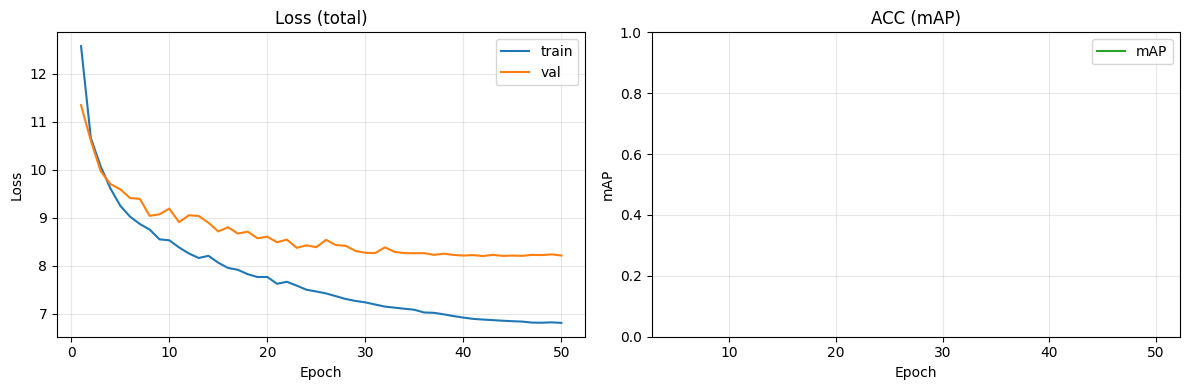

In [8]:
# 視覺化：Loss 與 ACC(mAP)
import matplotlib.pyplot as plt

epochs = list(range(1, len(history['train_total']) + 1))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, history['train_total'], label='train')
plt.plot(epochs, history['val_total'], label='val')
plt.title('Loss (total)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history['map'], label='mAP', color='tab:green')
plt.title('ACC (mAP)')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


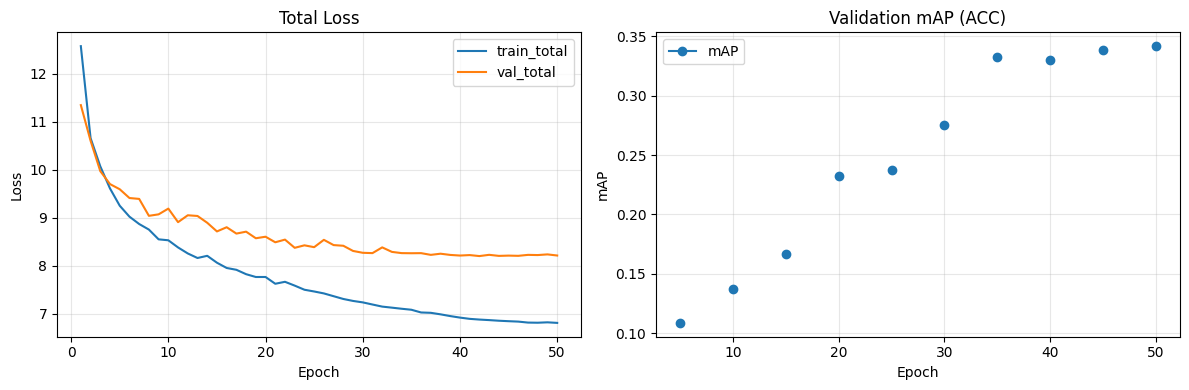

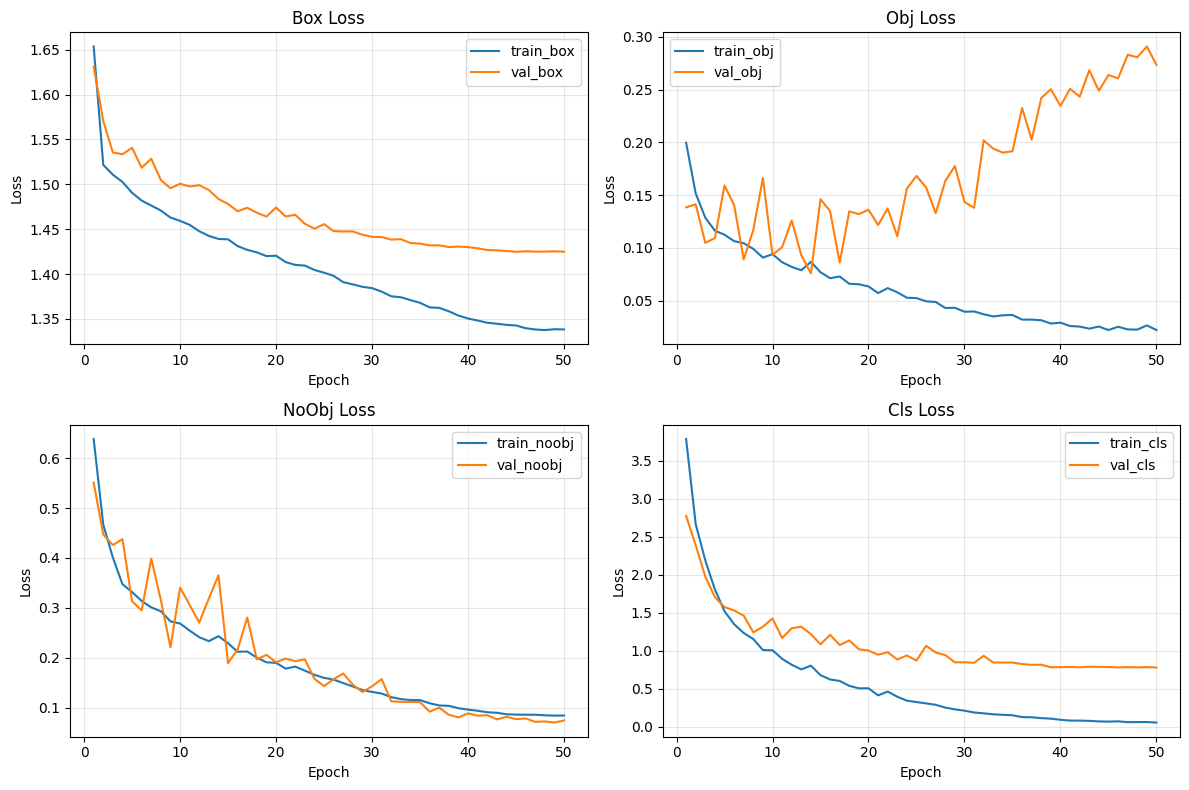

In [9]:
# Plot training/validation loss curves and mAP (ACC)
import matplotlib.pyplot as plt
import numpy as np

epochs = np.arange(1, len(history['train_total']) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_total'], label='train_total')
plt.plot(epochs, history['val_total'], label='val_total')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# mAP may be None on non-eval epochs; mask them
map_vals = np.array([np.nan if v is None else v for v in history['map']], dtype=float)
plt.plot(epochs, map_vals, marker='o', label='mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Validation mAP (ACC)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: component-wise loss trends
plt.figure(figsize=(12, 8))
comp_keys = [('box','Box'), ('obj','Obj'), ('noobj','NoObj'), ('cls','Cls')]
for idx, (k, name) in enumerate(comp_keys, start=1):
    plt.subplot(2, 2, idx)
    plt.plot(epochs, history[f'train_{k}'], label=f'train_{name.lower()}')
    plt.plot(epochs, history[f'val_{k}'], label=f'val_{name.lower()}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{name} Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()
plt.tight_layout()
plt.show()


# Kaggle submission

### Predict Result

Predict the results based on testing set. Upload to [Kaggle](https://www.kaggle.com/t/e86ea95cb007416a85a07d8729ac838e).

**How to upload**

1. Click the folder icon in the left hand side of Colab.
2. Right click "result.csv". Select "Download"
3. To kaggle. Click "Submit Predictions"
4. Upload the result.csv
5. System will automaticlaly calculate the accuracy of 50% dataset and publish this result to leaderboard.


In [10]:
!python predict_test.py

/bin/bash: /cm/shared/apps/anaconda/2024.02/lib/libtinfo.so.6: no version information available (required by /bin/bash)
